In [1]:
from pprint import pprint as pp
from typing import Dict, List, Tuple

import random
import csv

# Building Knowledge Graph

## Extract Data from CSV

In [2]:
def get_csv_data(filepath, handle_row_func):
    data = dict()
    with open(filepath) as file:
        next(file)
        rows = csv.reader(file, delimiter=",")
        for row in rows:
            handle_row_func(data, row)
    return data

In [3]:
def handle_csv_kanji_func(data, row):
    kanji,*meanings = row
    if len(meanings) >= 2:
        meanings = ",".join(meanings)
    else:
        meanings = meanings[0]
    meanings = meanings.split(":")
    meanings = meanings[0]
    data[kanji] = meanings

In [4]:
data_kanji = get_csv_data("dataset/s5_kanjis_output.csv", handle_csv_kanji_func)
print("len(data_kanji) = ", len(data_kanji))
pp(data_kanji)

len(data_kanji) =  6215
{'丁': 'street',
 '七': 'seven',
 '万': 'ten thousand',
 '丈': 'length',
 '三': 'three',
 '上': 'above',
 '下': 'below',
 '不': 'negative',
 '与': 'bestow',
 '丐': 'beggar',
 '丑': 'sign of the ox or cow',
 '且': 'moreover',
 '丕': 'large',
 '世': 'generation',
 '丗': 'thirty',
 '丘': 'hill',
 '丙': 'third class',
 '丞': 'help',
 '両': 'both',
 '並': 'row',
 '个': 'counter for articles',
 '中': 'in',
 '丱': 'saguaro-like kanji',
 '串': 'spit',
 '丸': 'round',
 '丹': 'rust-colored',
 '主': 'lord',
 '丼': 'bowl',
 '乂': 'mow',
 '乃': 'from',
 '久': 'long time',
 '之': 'of',
 '乍': 'though',
 '乎': 'question mark',
 '乏': 'destitution',
 '乕': 'tiger',
 '乖': 'oppose',
 '乗': 'ride',
 '乘': 'power',
 '乞': 'beg',
 '也': 'to be (classical)',
 '乢': 'mountain saddle',
 '乱': 'riot',
 '乳': 'milk',
 '乾': 'drought',
 '亀': 'tortoise',
 '亂': 'war',
 '了': 'complete',
 '予': 'beforehand',
 '争': 'contend',
 '亊': 'affair',
 '事': 'matter',
 '于': 'going',
 '云': 'say',
 '互': 'mutually',
 '五': 'five',
 '井': 'well',
 '亘': '

 '夙': 'bright and early',
 '多': 'many',
 '夛': 'much',
 '夜': 'night',
 '夢': 'dream',
 '夥': 'immense',
 '天': 'heavens',
 '太': 'plump',
 '夫': 'husband',
 '夬': 'decide',
 '夭': 'early death',
 '央': 'center',
 '失': 'lose',
 '夲': 'advance quickly',
 '夷': 'barbarian',
 '夸': 'boast',
 '夾': 'insert between',
 '奄': 'cover',
 '奇': 'strange',
 '奈': 'Nara',
 '奉': 'observance',
 '奎': 'star',
 '奏': 'play music',
 '奐': 'clear',
 '契': 'pledge',
 '奔': 'run',
 '奕': 'large',
 '套': 'accumulate',
 '奘': 'large',
 '奚': 'servant',
 '奠': 'decision',
 '奢': 'extravagance',
 '奥': 'heart',
 '奧': 'heart',
 '奨': 'exhort',
 '奩': "lady's vanity case",
 '奪': 'rob',
 '奬': 'prize',
 '奮': 'stirred up',
 '奴': 'guy',
 '奸': 'wickedness',
 '好': 'fond',
 '妁': 'go-between',
 '如': 'likeness',
 '妃': 'queen',
 '妄': 'delusion',
 '妊': 'pregnancy',
 '妍': 'beauty',
 '妓': 'stretch',
 '妖': 'attractive',
 '妙': 'exquisite',
 '妛': 'despise',
 '妝': 'dress up',
 '妣': 'mother',
 '妥': 'gentle',
 '妨': 'disturb',
 '妬': 'jealous',
 '妲': 'female pro

 '汁': 'soup',
 '求': 'request',
 '汎': 'pan-',
 '汐': 'eventide',
 '汕': 'fish swimming',
 '汗': 'sweat',
 '汚': 'dirty',
 '汝': 'you',
 '汞': 'mercury',
 '江': 'creek',
 '池': 'pond',
 '汢': 'wetland',
 '汨': 'to sink',
 '汪': 'flowing full',
 '汰': 'washing',
 '汲': 'draw (water)',
 '汳': 'proper name',
 '決': 'decide',
 '汽': 'vapor',
 '汾': 'name of a Chinese river',
 '沁': 'penetrate',
 '沂': 'name of a Chinese river',
 '沃': 'fertility',
 '沈': 'sink',
 '沌': 'primeval chaos',
 '沍': 'close up',
 '沐': 'wash',
 '沒': 'not',
 '沓': 'shoes',
 '沖': 'open sea',
 '沙': 'sand',
 '沚': 'shore',
 '沛': 'big rain',
 '没': 'drown',
 '沢': 'swamp',
 '沫': 'splash',
 '沮': 'stop',
 '沱': 'flowing of tears',
 '河': 'river',
 '沸': 'seethe',
 '油': 'oil',
 '沺': 'vast surging waters',
 '治': 'reign',
 '沼': 'marsh',
 '沽': 'price',
 '沾': 'moisten',
 '沿': 'run alongside',
 '況': 'condition',
 '泄': 'leak',
 '泅': 'swim',
 '泉': 'spring',
 '泊': 'overnight stay',
 '泌': 'ooze',
 '泓': 'deep clear water',
 '法': 'method',
 '泗': 'name of a Chinese

 '肺': 'lungs',
 '胃': 'stomach',
 '胄': 'lineage',
 '胆': 'gall bladder',
 '背': 'stature',
 '胎': 'womb',
 '胖': 'half a sacrifice',
 '胙': 'offerings to gods',
 '胚': 'embryo',
 '胛': 'shoulder blade',
 '胝': 'chap',
 '胞': 'placenta',
 '胡': 'barbarian',
 '胤': 'descendent',
 '胥': 'together',
 '胯': 'crotch',
 '胱': 'bladder',
 '胴': 'trunk',
 '胸': 'bosom',
 '胼': 'callus',
 '能': 'ability',
 '脂': 'fat',
 '脅': 'threaten',
 '脆': 'brittle',
 '脇': 'armpit',
 '脈': 'vein',
 '脉': 'vein (blood, ore)',
 '脊': 'stature',
 '脚': 'skids',
 '脛': 'leg',
 '脣': 'lip',
 '脩': 'dried meat',
 '脯': 'dried meat',
 '脱': 'undress',
 '脳': 'brain',
 '脹': 'dilate',
 '脾': 'spleen',
 '腆': 'much',
 '腋': 'armpit',
 '腎': 'kidney',
 '腐': 'rot',
 '腑': 'viscera',
 '腓': 'calf (of leg)',
 '腔': 'body cavity',
 '腕': 'arm',
 '腟': 'vagina',
 '腥': 'bloody',
 '腦': 'brain',
 '腫': 'tumor',
 '腮': 'jaw',
 '腰': 'loins',
 '腱': 'tendon',
 '腴': 'fat',
 '腸': 'intestines',
 '腹': 'abdomen',
 '腺': 'gland',
 '腿': 'thigh',
 '膀': 'bladder',
 '膂': 'backbone',

 '雕': 'carving',
 '雖': 'although',
 '雙': 'pair',
 '雛': 'chick',
 '雜': 'mixed',
 '離': 'detach',
 '難': 'difficult',
 '雪': 'snow',
 '雫': 'drop',
 '雰': 'atmosphere',
 '雲': 'cloud',
 '零': 'zero',
 '雷': 'thunder',
 '雹': 'hail',
 '電': 'electricity',
 '需': 'demand',
 '霄': 'sky',
 '霆': 'lightning',
 '震': 'quake',
 '霈': 'big rain',
 '霊': 'spirits',
 '霍': 'quick',
 '霎': 'light rain',
 '霏': 'falling rain or snow',
 '霑': 'moisten',
 '霓': 'rainbow',
 '霖': 'long rainy spell',
 '霙': 'sleet',
 '霜': 'frost',
 '霞': 'be hazy',
 '霤': 'raindrops falling from the eaves',
 '霧': 'fog',
 '霪': 'rain lasting at least ten days',
 '霰': 'hail',
 '露': 'dew',
 '霸': 'supremacy',
 '霹': 'thunder',
 '霽': 'clear up',
 '霾': 'wind-blown dust falling like rain',
 '靂': 'violent',
 '靄': 'mist',
 '靆': 'cloud cover',
 '靈': 'soul',
 '靉': 'clouds',
 '青': 'blue',
 '靖': 'peaceful',
 '静': 'quiet',
 '靜': 'quiet',
 '靠': 'lean on',
 '靡': 'flutter',
 '靤': 'pimple',
 '靦': 'unashamed',
 '靨': 'dimple',
 '革': 'leather',
 '靫': 'quiver',
 '靭': 

In [5]:
def handle_csv_radical_func(data, row):
    radical,meaning,_ = row
    data[radical] = meaning

In [6]:
data_radical = get_csv_data("dataset/s7_nodes_radical_meaning.csv", handle_csv_radical_func)
print("len(data_radical) = ", len(data_radical))
pp(data_radical)

len(data_radical) =  255
{'.阝': 'right village',
 'マ': 'kana ma',
 'ユ': 'kana yu',
 '世': 'generation',
 '个': 'human roof (top)',
 '丶': 'dot',
 '丷': 'eight-head',
 '丿': 'kana no',
 '乃': 'from',
 '久': 'long time',
 '乙': 'fish hook',
 '九': 'nine',
 '也': 'to be',
 '亅': 'feathered stick',
 '二': 'two',
 '五': 'five',
 '井': 'well',
 '亠': 'lid',
 '亡': 'deceased',
 '人': 'person',
 '亻': 'person',
 '儿': 'human legs',
 '元': 'beginning',
 '免': 'excuse',
 '入': 'enter',
 '八': 'eight',
 '冂': 'upside down box',
 '冊': 'tome',
 '冖': 'crown shaped wa',
 '冫': 'ice',
 '几': 'table',
 '凵': 'open box',
 '刀': 'sword',
 '刂': 'sword',
 '力': 'strong',
 '勹': 'wrapping',
 '勿': 'not',
 '匕': 'spoon',
 '匚': 'sideways box',
 '匸': 'hiding',
 '十': 'cross',
 '卜': 'divining rod',
 '卩': 'seal',
 '厂': 'cliff',
 '厶': 'myself',
 '又': 'again',
 '及': 'reach out',
 '口': 'mouth',
 '品': 'goods',
 '啇': 'antique',
 '囗': 'box',
 '土': 'earth',
 '士': 'samurai',
 '夂': 'winter',
 '夊': 'go slowly',
 '夕': 'evening',
 '大': 'big',
 '奄': 'cover'

In [7]:
def handle_csv_edges_func(data, row):
    kanji,radical_list = row
    data[kanji] = radical_list.split(':')

In [8]:
data_edges = get_csv_data("dataset/s7_edges_kanji_radical.csv", handle_csv_edges_func)
print("len(data_edges) = ", len(data_edges))
pp(data_edges)

len(data_edges) =  6215
{'丁': ['亅'],
 '七': ['丿', '乙', '匕'],
 '万': ['｜', '丿'],
 '丈': ['丶', '丿'],
 '三': ['二'],
 '上': ['卜'],
 '下': ['｜', '卜'],
 '不': ['｜', '丶', '丿'],
 '与': ['勹', '卜'],
 '丐': ['弓', '止', '疋'],
 '丑': ['｜', '丿'],
 '且': ['目'],
 '丕': ['｜', '丶', '丿'],
 '世': ['｜'],
 '丗': ['｜', '十', '山'],
 '丘': ['斤'],
 '丙': ['人', '冂'],
 '丞': ['丿', '亅', 'マ'],
 '両': ['｜', '冂', '山'],
 '並': ['｜', '二', '丷'],
 '个': ['｜'],
 '中': ['｜', '口'],
 '丱': ['｜', '丿'],
 '串': ['｜', '口'],
 '丸': ['丶', '九'],
 '丹': ['丶', '丿', '亅'],
 '主': ['丶', '玉'],
 '丼': ['｜', '丶', '丿', '二', '廾', '井'],
 '乂': ['丿'],
 '乃': ['｜', '丿'],
 '久': ['丿', '入'],
 '之': ['丶', '乙', '亠', '廴'],
 '乍': ['｜', '丿'],
 '乎': ['丿', '亅', '丷'],
 '乏': ['丶', '丿', '乙', '亠'],
 '乕': ['｜', '丿', '厂', '巾'],
 '乖': ['丿', '匕', '十', '爿'],
 '乗': ['｜', '丿', '八', '禾'],
 '乘': ['丿', '八', '匕', '十', '爿'],
 '乞': ['丿', '乙'],
 '也': ['｜', '乙', '匕'],
 '乢': ['乙', '山'],
 '乱': ['乙', '口', '舌'],
 '乳': ['乙', '子', '爪'],
 '乾': ['乙', '十', '日'],
 '亀': ['乙', '勹', '田', '龜'],
 '亂': ['乙', '冂', '厶', '

 '吟': ['口', '个'],
 '吠': ['口', '犬'],
 '否': ['丿', '口'],
 '吩': ['八', '刀', '口'],
 '含': ['口', '个'],
 '听': ['口', '斤'],
 '吭': ['亠', '几', '口'],
 '吮': ['儿', '厶', '口'],
 '吶': ['人', '冂', '口'],
 '吸': ['丿', '口', '及'],
 '吹': ['口', '欠'],
 '吻': ['勹', '口', '勿'],
 '吼': ['乙', '口', '子'],
 '吽': ['｜', '二', '口', '牛'],
 '吾': ['口', '五'],
 '呀': ['口', '牙'],
 '呂': ['口'],
 '呆': ['口', '木'],
 '呈': ['口', '玉'],
 '呉': ['八', '口'],
 '告': ['丿', '口', '土'],
 '呎': ['口', '尸'],
 '呑': ['丿', '口', '大'],
 '呟': ['亠', '口', '幺', '玄'],
 '周': ['冂', '口', '土'],
 '呪': ['儿', '口'],
 '呰': ['匕', '口', '止'],
 '呱': ['口', '瓜'],
 '味': ['｜', '二', '亠', '八', '口', '木'],
 '呵': ['亅', '口'],
 '呶': ['又', '口', '女'],
 '呷': ['｜', '口', '田'],
 '呻': ['｜', '口', '田'],
 '呼': ['丿', '亅', '口', '丷'],
 '命': ['卩', '口', '个'],
 '咀': ['口', '目'],
 '咄': ['｜', '口', '山'],
 '咆': ['勹', '口', '己'],
 '咋': ['｜', '丿', '口'],
 '和': ['口', '禾'],
 '咎': ['人', '口', '夂'],
 '咏': ['丶', '丿', '口', '水'],
 '咐': ['口', '寸', '亻'],
 '咒': ['几', '口'],
 '咢': ['二', '勹', '口'],
 '咤': ['丿', '乙', '口', '宀'],
 '

 '弑': ['工', '弋', '木'],
 '弔': ['｜', '弓'],
 '引': ['｜', '弓'],
 '弖': ['弓'],
 '弗': ['｜', '丿', '弓'],
 '弘': ['厶', '弓'],
 '弛': ['弓', '也'],
 '弟': ['｜', '丿', '弓', '丷'],
 '弥': ['丿', '亅', '小', '弓'],
 '弦': ['亠', '幺', '弓', '玄'],
 '弧': ['弓', '瓜'],
 '弩': ['又', '女', '弓'],
 '弭': ['弓', '耳'],
 '弯': ['亠', '八', '弓', '赤'],
 '弱': ['冫', '弓'],
 '張': ['弓', '長'],
 '強': ['厶', '弓', '虫'],
 '弸': ['弓', '月'],
 '弼': ['丿', '弓', '白'],
 '弾': ['十', '弓', '田', '尚'],
 '彁': ['亅', '口', '弓'],
 '彈': ['｜', '十', '口', '弓', '田'],
 '彊': ['弓', '田'],
 '彌': ['｜', '八', '冂', '弓', '爻'],
 '彎': ['弓', '糸', '言'],
 '彑': ['彐'],
 '当': ['彐', '尚'],
 '彖': ['豕', '彑'],
 '彗': ['二', '亠', '土', '彐'],
 '彙': ['冖', '彐', '木', '田', '彑'],
 '彜': ['刀', '廾', '彐', '米', '丷', '彑'],
 '彝': ['廾', '彐', '米', '糸', '彑'],
 '形': ['丿', '廾', '彡'],
 '彦': ['亠', '厂', '彡', '立', '丷'],
 '彩': ['彡', '木', '爪'],
 '彪': ['儿', '匕', '卜', '厂', '彡', '虍'],
 '彫': ['冂', '口', '土', '彡'],
 '彬': ['彡', '木'],
 '彭': ['口', '土', '彡', '豆', '丷'],
 '彰': ['十', '彡', '日', '立', '音'],
 '影': ['亠', '口', '小', '彡', '日'

 '旧': ['｜', '日'],
 '旨': ['匕', '日'],
 '早': ['十', '日'],
 '旬': ['勹', '日'],
 '旭': ['日', '九'],
 '旱': ['干', '日'],
 '旺': ['日', '玉'],
 '旻': ['文', '日'],
 '昂': ['卩', '日'],
 '昃': ['人', '厂', '日'],
 '昆': ['日', '比'],
 '昇': ['丿', '十', '廾', '日'],
 '昊': ['大', '日'],
 '昌': ['日'],
 '明': ['日', '月'],
 '昏': ['日', '氏'],
 '易': ['勹', '日', '勿'],
 '昔': ['｜', '二', '日'],
 '昜': ['丿', '日', '勿'],
 '星': ['日', '生'],
 '映': ['丿', '大', '日'],
 '春': ['丿', '二', '日'],
 '昧': ['｜', '二', '亠', '八', '日', '木'],
 '昨': ['｜', '丿', '日'],
 '昭': ['刀', '口', '日'],
 '是': ['日', '疋'],
 '昴': ['卩', '日'],
 '昵': ['匕', '尸', '日'],
 '昶': ['丶', '日', '水'],
 '昼': ['丶', '尸', '日'],
 '昿': ['厶', '广', '日'],
 '晁': ['儿', '冫', '日'],
 '時': ['土', '寸', '日'],
 '晃': ['儿', '日', '尚'],
 '晄': ['儿', '日', '尚'],
 '晉': ['二', '厶', '日'],
 '晋': ['日'],
 '晏': ['女', '宀', '日'],
 '晒': ['日', '襾'],
 '晝': ['日', '聿'],
 '晞': ['丿', '巾', '日'],
 '晟': ['丿', '戈', '日'],
 '晢': ['斤', '日', '扌'],
 '晤': ['口', '日', '五'],
 '晦': ['日', '毋'],
 '晧': ['丿', '口', '土', '日'],
 '晨': ['日', '辰'],
 '晩': ['儿', '日

 '當': ['冖', '口', '田', '尚'],
 '畷': ['又', '田'],
 '畸': ['亅', '口', '大', '田'],
 '畿': ['幺', '戈', '田'],
 '疂': ['冖', '冫', '田', '目'],
 '疆': ['土', '弓', '田'],
 '疇': ['口', '士', '寸', '工', '田'],
 '疉': ['宀', '彐', '田'],
 '疊': ['冖', '田', '目'],
 '疎': ['｜', '口', '木', '止', '疋'],
 '疏': ['亠', '厶', '巛', '止', '疋', 'マ'],
 '疑': ['匕', '疋', '矢', 'マ'],
 '疔': ['亅', '疒'],
 '疚': ['丿', '入', '疒', '久'],
 '疝': ['山', '疒'],
 '疣': ['丶', '尢', '疒', '尤'],
 '疥': ['｜', '丿', '疒', '个'],
 '疫': ['殳', '疒'],
 '疱': ['勹', '己', '疒'],
 '疲': ['又', '疒', '皮'],
 '疳': ['甘', '疒'],
 '疵': ['匕', '止', '疒'],
 '疸': ['日', '疒'],
 '疹': ['彡', '疒', '个'],
 '疼': ['丶', '冫', '夂', '疒'],
 '疽': ['疒', '目'],
 '疾': ['疒', '矢'],
 '痂': ['力', '口', '疒'],
 '痃': ['亠', '幺', '玄', '疒'],
 '病': ['人', '冂', '疒'],
 '症': ['止', '疒'],
 '痊': ['玉', '疒', '个'],
 '痍': ['人', '大', '弓', '疒'],
 '痒': ['玉', '疒', '羊', '丷'],
 '痔': ['土', '寸', '疒'],
 '痕': ['疒', '艮'],
 '痘': ['口', '疒', '豆', '丷'],
 '痙': ['巛', '工', '疒'],
 '痛': ['用', '疒', 'マ'],
 '痞': ['｜', '丶', '丿', '口', '疒'],
 '痢': ['疒', '禾', '刂'],
 '

 '篏': ['欠', '甘', '竹'],
 '篝': ['｜', '二', '冂', '竹'],
 '篠': ['｜', '攴', '木', '竹', '亻'],
 '篤': ['竹', '馬', '鳥', '灬'],
 '篥': ['木', '竹', '襾'],
 '篦': ['囗', '比', '竹'],
 '篩': ['口', '巾', '竹'],
 '篭': ['立', '竹', '竜'],
 '篳': ['｜', '日', '田', '竹'],
 '篶': ['止', '竹', '鳥', '灬'],
 '篷': ['夂', '竹', '辶'],
 '簀': ['二', '亠', '土', '竹', '貝'],
 '簇': ['方', '矢', '竹'],
 '簍': ['｜', '口', '女', '竹'],
 '簑': ['亠', '口', '竹', '衣'],
 '簒': ['厶', '大', '目', '竹'],
 '簓': ['冂', '十', '口', '彡', '竹'],
 '簔': ['亠', '口', '竹', '衣'],
 '簗': ['丶', '刀', '木', '竹', '氵'],
 '簟': ['十', '日', '曰', '竹', '襾'],
 '簡': ['日', '竹', '門'],
 '簣': ['｜', '口', '竹', '貝'],
 '簧': ['八', '田', '竹', '黄'],
 '簪': ['无', '日', '竹'],
 '簫': ['｜', '丿', '彐', '水', '竹', '聿', '隶'],
 '簷': ['儿', '厂', '竹', '言'],
 '簸': ['又', '甘', '皮', '竹'],
 '簽': ['人', '口', '竹', '个'],
 '簾': ['｜', '八', '广', '彐', '竹'],
 '簿': ['丶', '十', '寸', '田', '竹', '氵'],
 '籀': ['刀', '厶', '田', '竹', '扌'],
 '籃': ['二', '皿', '竹', '臣'],
 '籌': ['口', '士', '寸', '工', '竹'],
 '籍': ['｜', '亠', '八', '土', '日', '木', '竹', '耒'],
 '籏': ['

 '豬': ['日', '老', '豕'],
 '豹': ['丶', '勹', '豸'],
 '豺': ['丿', '亅', '豸'],
 '豼': ['比', '豸'],
 '貂': ['刀', '口', '豸'],
 '貅': ['木', '豸', '亻'],
 '貉': ['口', '夂', '豸'],
 '貊': ['白', '豸'],
 '貌': ['儿', '白', '豸'],
 '貍': ['豸', '里'],
 '貎': ['儿', '臼', '豸'],
 '貔': ['囗', '比', '豸'],
 '貘': ['大', '日', '豸', '艹'],
 '貝': ['八', '目'],
 '貞': ['卜', '貝'],
 '負': ['勹', '貝'],
 '財': ['丿', '亅', '貝'],
 '貢': ['工', '貝'],
 '貧': ['八', '刀', '貝'],
 '貨': ['匕', '貝', '亻'],
 '販': ['厂', '又', '貝'],
 '貪': ['貝', '个'],
 '貫': ['毋', '貝'],
 '責': ['亠', '土', '貝'],
 '貭': ['十', '厂', '貝'],
 '貮': ['弋', '貝'],
 '貯': ['亅', '宀', '貝'],
 '貰': ['貝', '世'],
 '貲': ['匕', '止', '貝'],
 '貳': ['二', '弋', '貝'],
 '貴': ['｜', '口', '貝'],
 '貶': ['丿', '乙', '亠', '貝'],
 '買': ['网', '貝'],
 '貸': ['弋', '貝', '亻'],
 '費': ['｜', '弓', '貝'],
 '貼': ['卜', '口', '貝'],
 '貽': ['厶', '口', '貝'],
 '貿': ['刀', '厶', '貝'],
 '賀': ['力', '口', '貝'],
 '賁': ['十', '貝', '艹'],
 '賂': ['口', '夂', '貝'],
 '賃': ['玉', '貝', '亻'],
 '賄': ['丿', '月', '貝'],
 '資': ['冫', '欠', '貝'],
 '賈': ['襾', '貝'],
 '賊': ['十', '戈', '貝'

## Data Structure

In [9]:
class KanjiNode:
    def __init__(self, symbol: str, dtype: str, meaning: str):
        self.symbol  = symbol
        self.dtype   = dtype
        self.meaning = meaning        
        self.color = 'red' if dtype == 'kanji' else 'orange'
        
    def __repr__(self):
        return self.symbol + '*' + self.dtype + '*' + self.meaning
    
    def __str__(self):
        return self.symbol + '\n' + self.meaning

In [10]:
class KanjiGraph:
    
    def __init__(self, data_kanji, data_radical, data_edges):
        self.nodes_kanji   = { s: KanjiNode(s, 'kanji', m)   for s, m in data_kanji.items()}
        self.nodes_radical = { s: KanjiNode(s, 'radical', m) for s, m in data_radical.items()}
        
        self.nodes = list(self.nodes_kanji.values()) + list(self.nodes_radical.values())
        
        self.edges = self.convert_into_data_edges(data_edges)
    
    def get_node(self, symbol, dtype):
        if dtype == 'kanji':
            mp = self.nodes_kanji
        elif dtype == 'radical':
            mp = self.nodes_radical
        else:
            raise ValueError(f"{dtype} is not valid")
        if symbol not in mp:
#             raise ValueError(f"{symbol} is not 1 of {len(mp)} nodes_{dtype}")
            return None
        return mp[symbol]
    
    def convert_into_data_edges(self, data_edges):
        kanjigen_edges = []
        
        for kanji, radical_list in data_edges.items():
            kanji_node = self.get_node(kanji, 'kanji')
            if kanji_node != None:
                for r in radical_list:
                    radical_node = self.get_node(r, 'radical')
                    kanjigen_edges.append( (kanji_node, radical_node) )
        return list(set(kanjigen_edges))

In [11]:
kjg = KanjiGraph(data_kanji, data_radical, data_edges)

In [12]:
print(kjg.get_node('人', 'radical'))

人
person


In [13]:
kjg.nodes[:3]

[亜*kanji*Asia, 唖*kanji*mute, 逢*kanji*meeting]

In [14]:
kjg.nodes_kanji

{'亜': 亜*kanji*Asia,
 '唖': 唖*kanji*mute,
 '逢': 逢*kanji*meeting,
 '悪': 悪*kanji*bad,
 '以': 以*kanji*by means of,
 '伊': 伊*kanji*Italy,
 '井': 井*kanji*well,
 '稲': 稲*kanji*rice plant,
 '印': 印*kanji*stamp,
 '引': 引*kanji*pull,
 '鵜': 鵜*kanji*cormorant,
 '丑': 丑*kanji*sign of the ox or cow,
 '渦': 渦*kanji*whirlpool,
 '焔': 焔*kanji*flame,
 '艶': 艶*kanji*glossy,
 '押': 押*kanji*push,
 '横': 横*kanji*sideways,
 '沖': 沖*kanji*open sea,
 '下': 下*kanji*below,
 '果': 果*kanji*fruit,
 '華': 華*kanji*splendor,
 '嘩': 嘩*kanji*noisy,
 '柿': 柿*kanji*persimmon,
 '角': 角*kanji*angle,
 '樺': 樺*kanji*birch,
 '鴨': 鴨*kanji*wild duck,
 '患': 患*kanji*afflicted,
 '諌': 諌*kanji*admonish,
 '陥': 陥*kanji*collapse,
 '貴': 貴*kanji*precious,
 '糾': 糾*kanji*twist,
 '旧': 旧*kanji*old times,
 '供': 供*kanji*submit,
 '叫': 叫*kanji*shout,
 '業': 業*kanji*business,
 '曲': 曲*kanji*bend,
 '巾': 巾*kanji*towel,
 '串': 串*kanji*spit,
 '屈': 屈*kanji*yield,
 '掘': 掘*kanji*dig,
 '窟': 窟*kanji*cavern,
 '勲': 勲*kanji*meritorious deed,
 '薫': 薫*kanji*send forth fragrance,
 '慧':

In [15]:
kjg.edges[:3]

[(裼*kanji*to bare the shoulder, 丿*radical*kana no),
 (牡*kanji*male, 牛*radical*cow),
 (狭*kanji*cramped, 二*radical*two)]

## Graph

In [16]:
import networkx as nx

In [17]:
G = nx.Graph()

G.add_nodes_from(kjg.nodes)
G.add_edges_from(kjg.edges)

print("nodes:", list(G.nodes())[:5])
print("edges:", list(G.edges())[:2])

nodes: [亜*kanji*Asia, 唖*kanji*mute, 逢*kanji*meeting, 悪*kanji*bad, 以*kanji*by means of]
edges: [(亜*kanji*Asia, 口*radical*mouth), (亜*kanji*Asia, ｜*radical*stick)]


## Visualization

In [18]:
import matplotlib
import matplotlib.pyplot as plt

### Install Font

In [19]:
import matplotlib.font_manager as fm

# Reference: https://albertauyeung.github.io/2020/03/15/matplotlib-cjk-fonts.html
[f for f in fm.fontManager.ttflist if 'CJK JP' in f.name]

[<Font 'Noto Serif CJK JP' (NotoSerifCJK-Regular.ttc) normal normal 400 normal>,
 <Font 'Noto Sans CJK JP' (NotoSansCJK-Bold.ttc) normal normal 700 normal>,
 <Font 'Noto Serif CJK JP' (NotoSerifCJK-Bold.ttc) normal normal 700 normal>,
 <Font 'Noto Sans CJK JP' (NotoSansCJK-Regular.ttc) normal normal 400 normal>]

In [20]:
def visualize_graph(Graph: nx.Graph, figsize: tuple=(15,15), color_map: List[str]=None, node_size: int=3000, with_labels: bool=True) -> None:
    if color_map == None:
        color_map = [n.color for n in Graph]  
    else:
        color_map = color_map
    
    plt.figure(1,figsize=figsize) 
    nx.draw_kamada_kawai(Graph, node_color=color_map, with_labels=with_labels, node_size=node_size, font_size=20,font_family="Noto Serif CJK JP")
    plt.show()

### Sample Visualization

In [21]:
def get_sg_kanji_with() -> nx.Graph:
    sg = nx.Graph()
    p = kjg.get_node('痘', 'kanji')
    radical_p = [n for n in G.neighbors(p)]
    sg.add_nodes_from(radical_p + [p])
    sg.add_edges_from([(p, rp) for rp in radical_p])
    return sg

In [22]:
sg = dict() # sample_graph
sg['full_graph'] = G
sg['sample_nodes'] = lambda size: G.subgraph(random.sample(G.nodes, size))
sg['kanji_plus_radical_neighbor'] = get_sg_kanji_with()

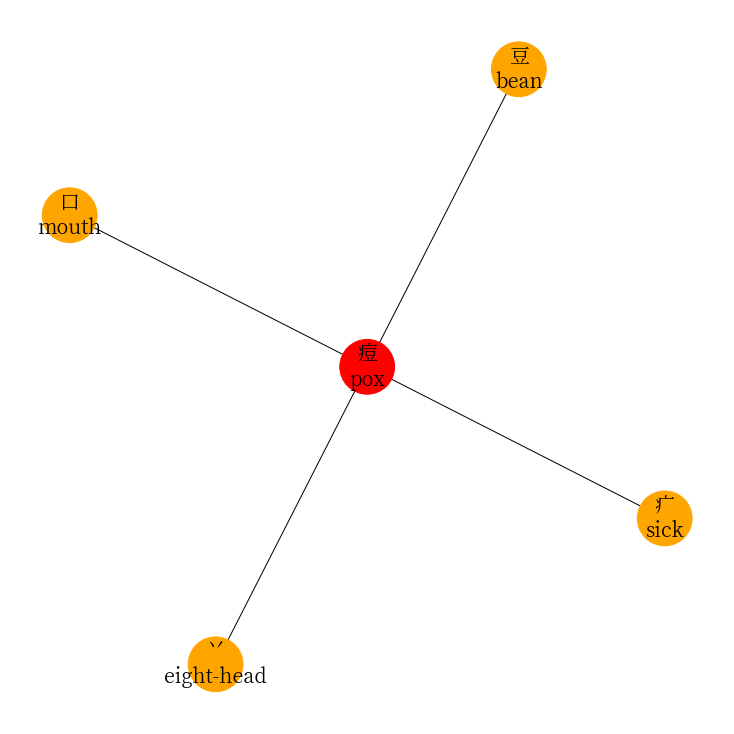

In [23]:
visualize_graph(Graph=sg['kanji_plus_radical_neighbor'], figsize=(10,10))

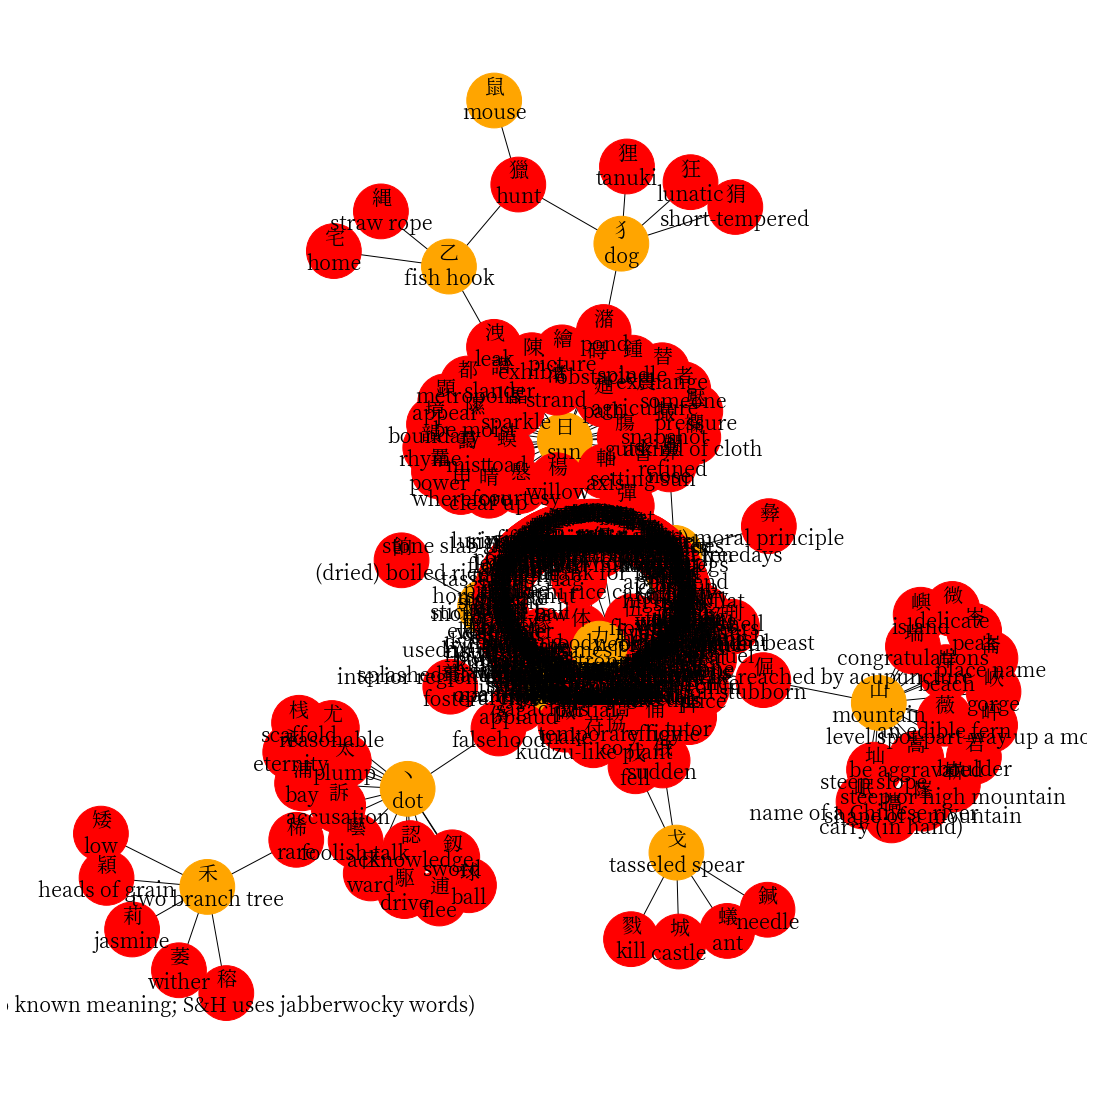

In [24]:
visualize_graph(Graph=sg['sample_nodes'](400), figsize=(15,15))

In [25]:
# visualize_graph(Graph=sg['full_graph'], node_size=1000, with_labels=False)

# Querying Knowledge Graph

## Exploratory Data Analysis

In [26]:
print(nx.info(G))

Graph with 6470 nodes and 22273 edges


In [27]:
# https://networkx.org/documentation/stable/reference/algorithms/component.html

print('number of connected components: ', nx.number_connected_components(G))

number of connected components:  10


In [28]:
# https://networkx.org/documentation/stable/reference/algorithms/isolates.html
# EDA + Preprocessing: Removing Isolated Nodes

print('number of isolated: ', nx.number_of_isolates(G))
isolated_nodes = [k for k in kjg.nodes if k in nx.isolates(G)]
pp(isolated_nodes)

# trim kjg node
for k in isolated_nodes:
    if k.dtype == 'kanji':
        kjg.nodes_kanji.pop(k, None)
    elif k.dtype =='radical':
        kjg.nodes_radical.pop(k, None)
kjg.nodes = list(kjg.nodes_kanji.values()) + list(kjg.nodes_radical.values())

# trim G node
G.remove_nodes_from(list(nx.isolates(G)))

number of isolated:  9
[匸*radical*hiding,
 夊*radical*go slowly,
 艸*radical*grass,
 辵*radical*road,
 邑*radical*right village,
 阜*radical*left village,
 鬯*radical*fragrant herbs,
 鼎*radical*three legged kettle,
 龍*radical*dragon]


In [29]:
print(nx.info(G))

# https://networkx.org/documentation/stable/reference/algorithms/component.html

print('number of connected components: ', nx.number_connected_components(G))

Graph with 6461 nodes and 22273 edges
number of connected components:  1


## Data Structure

In [30]:
def generate_graph(nodes: List[KanjiNode]) -> nx.Graph:
    R = nx.Graph()
    R.add_nodes_from(nodes)
    R.add_edges_from(nx.utils.pairwise(nodes))
    return R

In [31]:
def get_node_color_result(kinputs, koutputs, union_result):
    color_map = []
    for n in union_result:
        if n in kinputs:
            color_map.append("green")
        elif n in koutputs:
            color_map.append("blue")
        else:
            color_map.append(n.color)
    return color_map

## User Input

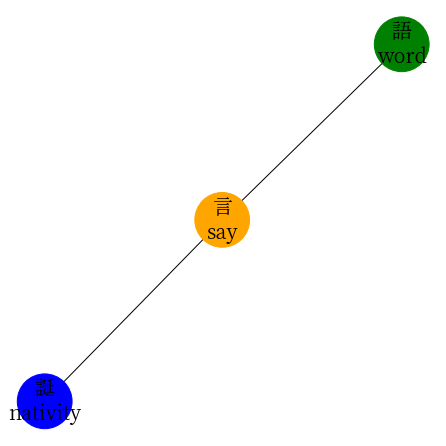

In [32]:
kin = kjg.get_node('語', 'kanji')  # say
kout = kjg.get_node('誕', 'kanji') # lie 

result_shortest_path = nx.shortest_path(G, source=kin, target=kout)
result = generate_graph(result_shortest_path)
visualize_graph(Graph=result, color_map=get_node_color_result([kin], [kout], result), figsize=(6,6))

### Test Case

In [34]:
def get_tc(filepath: str):
    fullpath = f"testcase/{filepath}"
    with open(fullpath) as file:
        return [row.strip() for row in file.readlines()]
    return None

In [35]:
tc_kanji_raw = [(get_tc(f"{i}.in"),get_tc(f"{i}.out")) for i in range(1,6)]

tc_kanji_clean = [{
        'MOrig': [kjg.get_node(o, 'kanji') for o in tc[0] if kjg.get_node(o, 'kanji')],
        'MDest': [kjg.get_node(o, 'kanji') for o in tc[1] if kjg.get_node(o, 'kanji')]
    } for tc in tc_kanji_raw]

In [36]:
pp(tc_kanji_clean[1])

{'MDest': [分*kanji*part,
           禾*kanji*two-branch tree radical (no. 115),
           私*kanji*private,
           中*kanji*in,
           尹*kanji*an official rank,
           事*kanji*matter,
           可*kanji*can,
           何*kanji*what,
           乂*kanji*mow,
           皮*kanji*pelt,
           彼*kanji*he,
           間*kanji*interval,
           本*kanji*book],
 'MOrig': [丁*kanji*street,
           行*kanji*going,
           寺*kanji*Buddhist temple,
           時*kanji*time,
           上*kanji*above]}


## Algorithm

### Brute Force Algorithm

In [37]:
def find_path_bf(MOrig: List[KanjiNode], MDest: List[KanjiNode]) -> nx.Graph:
    
    result = []
    
    for kin in MOrig:
        for kout in MDest:
            sp_raw = nx.dijkstra_path(G, source=kin, target=kout)
            sp_graph = generate_graph(sp_raw)
            
            result.append(sp_graph)
    
    
    return nx.compose_all(result)        

### Astar Algorithm

In [38]:
def find_path_astar(MOrig: List[KanjiNode], MDest: List[KanjiNode], heuristic_func) -> nx.Graph:
    
    result = []
    
    for kin in MOrig:
        for kout in MDest:
            sp_raw = nx.astar_path(G, source=kin, target=kout, heuristic=heuristic_func)
            sp_graph = generate_graph(sp_raw)
            
            result.append(sp_graph)
    
    
    return nx.compose_all(result)        

#### Heuristic

In [39]:
def common_neighbor(u, v):
    return len(list(nx.common_neighbors(G, u, v)))

In [40]:
def jaccard_function(u, v):
    union_size = len(set(G[u]) | set(G[v])) # union neighbor
    if union_size == 0:
        return 0
    return len(list(nx.common_neighbors(G, u, v))) / union_size

### Steiner Tree

In [41]:
all_pairs_dijkstra = nx.all_pairs_dijkstra(G, weight='weight')

In [42]:
def metric_closure(G, weight="weight"):
    M = nx.Graph()

    Gnodes = set(G)

    # check for connected graph while processing first node
    all_paths_iter = all_pairs_dijkstra
    u, (distance, path) = next(all_paths_iter)
    if Gnodes - set(distance):
        msg = "G is not a connected graph. metric_closure is not defined."
        raise nx.NetworkXError(msg)
    Gnodes.remove(u)
    for v in Gnodes:
        M.add_edge(u, v, distance=distance[v], path=path[v])

    # first node done -- now process the rest
    for u, (distance, path) in all_paths_iter:
        Gnodes.remove(u)
        for v in Gnodes:
            M.add_edge(u, v, distance=distance[v], path=path[v])

    return M

In [43]:
def steiner_tree(G, terminal_nodes, weight="weight"):
    # H is the subgraph induced by terminal_nodes in the metric closure M of G.
    M = metric_closure(G, weight=weight)
    H = M.subgraph(terminal_nodes)
    # Use the 'distance' attribute of each edge provided by M.
    mst_edges = nx.minimum_spanning_edges(H, weight="distance", data=True)
    # Create an iterator over each edge in each shortest path; repeats are okay
    edges = chain.from_iterable(pairwise(d["path"]) for u, v, d in mst_edges)
    # For multigraph we should add the minimal weight edge keys
    if G.is_multigraph():
        edges = (
            (u, v, min(G[u][v], key=lambda k: G[u][v][k][weight])) for u, v in edges
        )
    T = G.edge_subgraph(edges)
    return T

In [44]:
def find_path_steiner(MOrig: List[KanjiNode], MDest: List[KanjiNode]) -> nx.Graph:
    
    return nx.steiner_tree(G, MOrig + MDest)     

In [45]:
# result = find_path_steiner(MOrig, MDest)
# result.nodes()

# Evaluation

In [46]:
def find_path(MOrig: List[KanjiNode], MDest: List[KanjiNode], method='brute_force') -> nx.Graph:
    if method == 'brute_force':
        return find_path_bf(MOrig, MDest)
    elif method == 'steiner_tree':
        return find_path_steiner(MOrig, MDest)
    elif method == 'astar_common_neighbor':
        return find_path_astar(MOrig, MDest, common_neighbor)
    elif method == 'astar_jaccard':
        return find_path_astar(MOrig, MDest, jaccard_function)
    elif method == 'astar_0':
        return find_path_astar(MOrig, MDest, lambda x, y: 0)
    else:
        raise ValueError(f"method {method} is not valid")

## Testing

In [47]:
import time

start = time.time()
print("hello")
end = time.time()
print(f"{end - start} seconds")

hello
0.00016164779663085938 seconds


In [48]:
tc_kanji_clean = [tc for tc in tc_kanji_clean if tc['MOrig'] and tc['MDest']]

In [49]:
tc_kanji_clean

[{'MOrig': [口*kanji*mouth],
  'MDest': [見*kanji*see,
   出*kanji*exit,
   未*kanji*un-,
   来*kanji*come,
   了*kanji*complete,
   思*kanji*think]},
 {'MOrig': [丁*kanji*street,
   行*kanji*going,
   寺*kanji*Buddhist temple,
   時*kanji*time,
   上*kanji*above],
  'MDest': [分*kanji*part,
   禾*kanji*two-branch tree radical (no. 115),
   私*kanji*private,
   中*kanji*in,
   尹*kanji*an official rank,
   事*kanji*matter,
   可*kanji*can,
   何*kanji*what,
   乂*kanji*mow,
   皮*kanji*pelt,
   彼*kanji*he,
   間*kanji*interval,
   本*kanji*book]},
 {'MOrig': [気*kanji*spirit,
   干*kanji*dry,
   年*kanji*year,
   三*kanji*three,
   者*kanji*someone,
   前*kanji*in front,
   勿*kanji*not],
  'MDest': [家*kanji*house,
   今*kanji*now,
   下*kanji*below,
   勺*kanji*ladle,
   的*kanji*bull's eye,
   云*kanji*say,
   物*kanji*thing,
   矢*kanji*dart,
   知*kanji*know,
   乍*kanji*though,
   作*kanji*make,
   書*kanji*write,
   学*kanji*study,
   合*kanji*fit,
   夂*kanji*late,
   後*kanji*behind,
   持*kanji*hold,
   古*kanji*old,
   居*k

## Get Results: Node and Time

In [50]:
def get_results_kanjigen(algo_list):
    results = {algo: dict() for algo in algo_list}

    for idx, tc in enumerate(tc_kanji_clean):
        MOrig = tc['MOrig']
        MDest = tc['MDest']

        for algo in algo_list:
            print(f"algo: {algo}")
            print(f"tc: {idx} of {len(tc_kanji_clean)}")
            print("==============")
            start  = time.time()
            result = find_path(MOrig, MDest, algo)
            end    = time.time()

            results[algo][idx] = {'time': (end - start), 'result': result}
    
    return results

In [51]:
algo_list = ['brute_force', 'astar_common_neighbor', 'astar_jaccard', 'astar_0']
results = get_results_kanjigen(algo_list)

algo: brute_force
tc: 0 of 5
algo: astar_common_neighbor
tc: 0 of 5
algo: astar_jaccard
tc: 0 of 5
algo: astar_0
tc: 0 of 5
algo: brute_force
tc: 1 of 5
algo: astar_common_neighbor
tc: 1 of 5
algo: astar_jaccard
tc: 1 of 5
algo: astar_0
tc: 1 of 5
algo: brute_force
tc: 2 of 5
algo: astar_common_neighbor
tc: 2 of 5
algo: astar_jaccard
tc: 2 of 5
algo: astar_0
tc: 2 of 5
algo: brute_force
tc: 3 of 5
algo: astar_common_neighbor
tc: 3 of 5
algo: astar_jaccard
tc: 3 of 5
algo: astar_0
tc: 3 of 5
algo: brute_force
tc: 4 of 5
algo: astar_common_neighbor
tc: 4 of 5
algo: astar_jaccard
tc: 4 of 5
algo: astar_0
tc: 4 of 5


In [54]:
results

{'brute_force': {0: {'time': 0.2534351348876953,
   'result': <networkx.classes.graph.Graph at 0x7f3c535215b0>},
  1: {'time': 2.0835766792297363,
   'result': <networkx.classes.graph.Graph at 0x7f3c35abd1f0>},
  2: {'time': 16.188015699386597,
   'result': <networkx.classes.graph.Graph at 0x7f3c35e7d400>},
  3: {'time': 37.87006759643555,
   'result': <networkx.classes.graph.Graph at 0x7f3c359f9760>},
  4: {'time': 126.56801223754883,
   'result': <networkx.classes.graph.Graph at 0x7f3c2f3d3910>}},
 'astar_common_neighbor': {0: {'time': 0.7101213932037354,
   'result': <networkx.classes.graph.Graph at 0x7f3c35f9a550>},
  1: {'time': 7.545104742050171,
   'result': <networkx.classes.graph.Graph at 0x7f3c35abddf0>},
  2: {'time': 61.69482731819153,
   'result': <networkx.classes.graph.Graph at 0x7f3c35e16790>},
  3: {'time': 138.70617604255676,
   'result': <networkx.classes.graph.Graph at 0x7f3c855f6310>},
  4: {'time': 444.8927073478699,
   'result': <networkx.classes.graph.Graph at 0

## Get Results: Accuracy

### Baseline: Brute Force

In [52]:
# https://networkx.org/documentation/stable/reference/algorithms/similarity.html

### Results Accuracy

In [53]:
G1 = nx.cycle_graph(6)
G2 = nx.wheel_graph(7)
nx.graph_edit_distance(G1, G2)

7.0